# CLAHE kernel implementation test in pyClesperanto

This notebook call the clahe opencl kernel updated to opencl clesperanto code and execute it using the pyClesperanto library.

In [1]:
import pyclesperanto as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

cle.select_device()

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.183.06
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Maximum Object Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

# Load test image

We load one of the test image and display it for good measure.

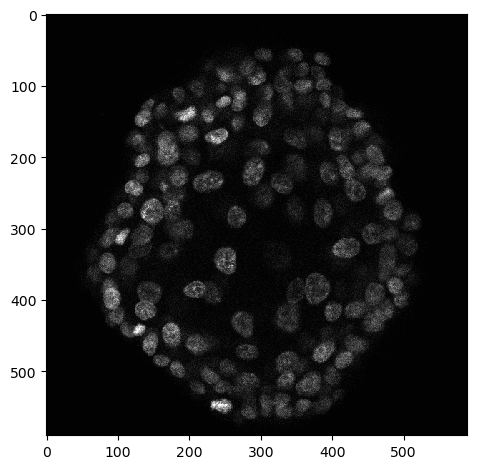

In [2]:
image = "./Test_image/TOrg2 DAPI-1.tif"
raw = imread(image)
imshow(raw[12])

# Run kernel using pycle

We have simply updated the kernel from pure opencl to clesperanto opencl, now we can use the `execute` function from the library to execute the kernel for tests.
First thing first, we need to `push` the raw image to the GPU, and prepare the output image memory.

In [3]:
gpu_raw = cle.push(raw.astype(np.uint8))
gpu_res = cle.create_like(gpu_raw)

__IMPORTANT:__ Currently the implementation is only `uint8` type compatible. Hence we enfore the `dtype` convertion to `uint8`

Next, we prepare the other kernel parameters. `tileSize` and `clipLimit` are constant predefined by the user, min/max intensity can be compute from the raw image. In this case we can rely on other pycle operation min and max of all pixels.

In [4]:
minIntensity = cle.minimum_of_all_pixels(gpu_raw)
maxIntensity = cle.maximum_of_all_pixels(gpu_raw)
tileSize = 8
clipLimit = 0.01 * 255# top 1% of the histogram for an 8-bit image

All we have left now is to get all the parameters in a `dict` structure with key corresponding to their parameter name in the kernel, and call the `execute` function of pycle on the kernel file.

In [5]:
params = {"src": gpu_raw, "dst": gpu_res, "tileSize":tileSize, "clipLimit":clipLimit, "minIntensity": minIntensity, "maxIntensity": maxIntensity}
cle.execute(anchor=".", kernel_source="clahe.cl", kernel_name="clahe", device=cle.get_device(), global_size=gpu_raw.shape, parameters=params)

We can pull back from the GPU the result image

In [8]:
results_gpu = cle.pull(gpu_res)
results_gpu.shape

(24, 590, 590)

Display the results compared with the raw image

(24, 590)


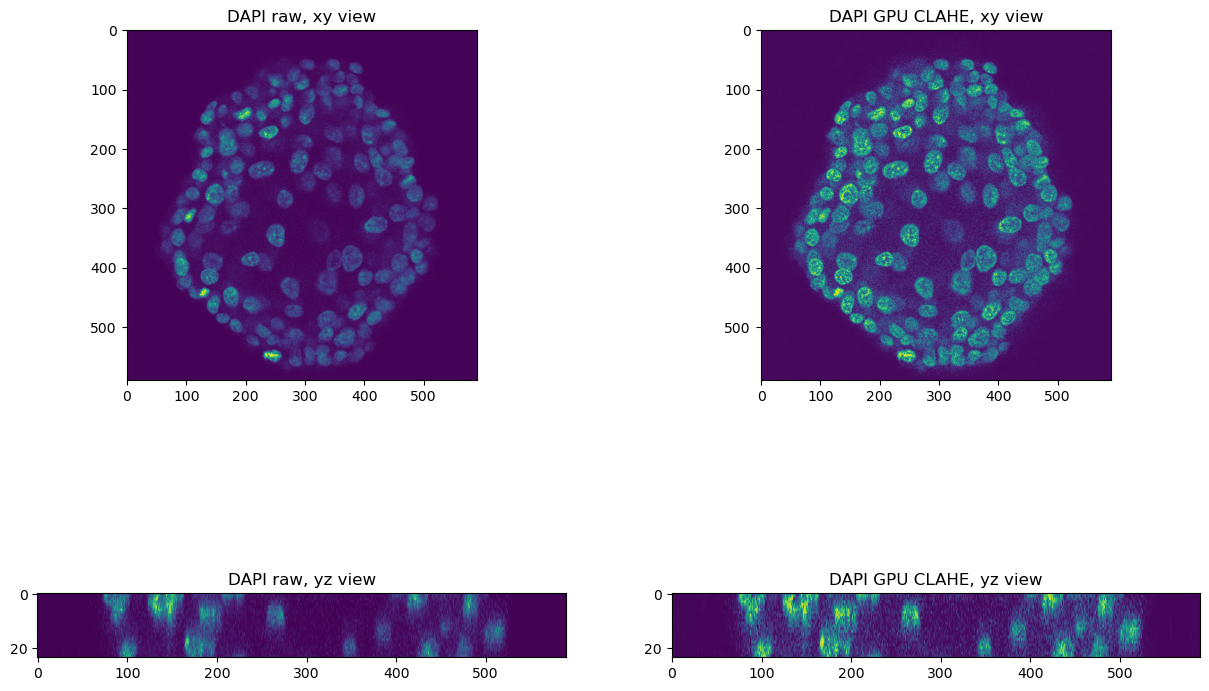

In [12]:
halfz = int(np.shape(raw)[0]/2)
halfx = int(np.shape(raw)[2]/2)

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0][0].imshow(raw[halfz])
axs[0][1].imshow(results_gpu[halfz])
axs[1][0].imshow(raw[:,halfx,:], aspect = 3)
axs[1][1].imshow(results_gpu[:,halfx,:], aspect = 3)
axs[0][0].set_title('DAPI raw, xy view')
axs[0][1].set_title('DAPI GPU CLAHE, xy view')
axs[1][0].set_title('DAPI raw, yz view')
axs[1][1].set_title('DAPI GPU CLAHE, yz view')
plt.show()